In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Runs on mdu kernel 

import random
import os
import re
from rdkit import Chem
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from tqdm import tqdm
import datasets
from datasets import concatenate_datasets
from PIL import Image, ImageDraw, ImageOps
from datasets import concatenate_datasets, Dataset, DatasetDict
from time import time
import functools

from docmarker.text_generation import DescriptionGenerator
from docmarker.image_text_merging import ImageTextMerger
from mol_depict_cdk.cxsmiles_tokenizer import CXSMILESTokenizer

/mnt/volume/lum/multimodal-chemical-understanding/mdu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [86]:
dataset_name = "ocxsr_3005"
dataset_hf = datasets.load_from_disk(os.getcwd() + f"/../../../molecule-depictor-cdk/data/hf_dataset/{dataset_name}/", keep_in_memory=False)
dataset_hf = concatenate_datasets((dataset_hf["train"], dataset_hf["test"]))
dataset_hf

Dataset({
    features: ['id', 'image_path', 'mol', 'cxsmiles', 'cxsmiles_dataset', 'keypoints', 'cells', 'image', 'cxsmiles_opt'],
    num_rows: 217575
})

In [5]:
dataset_name = "lum_test_hf_2"
dataset_hf = datasets.load_from_disk(os.getcwd() + f"/../../../deepsearch-ai-unidoc/data/{dataset_name}/", keep_in_memory=False)
dataset_hf = dataset_hf["test"]
dataset_hf = dataset_hf.rename_column("page_image", "image")

def add_column(example):
    example["image_path"] = ""
    return example
dataset_hf = dataset_hf.map(add_column)

dataset_hf

Dataset({
    features: ['id', 'image', 'description', 'annotation', 'mol', 'cxsmiles_dataset', 'cxsmiles', 'cxsmiles_opt', 'keypoints', 'cells', 'image_path'],
    num_rows: 53
})

### Test CXSMILES labels parsing

In [ ]:
for id in range(20, 22):
    print(dataset_hf[id]["cxsmiles"])
    print(dataset_hf[id]["cxsmiles_dataset"])
    print(dataset_hf[id]["cxsmiles_opt"])
    cxsmiles_tokenizer = CXSMILESTokenizer()
    text_aliases = cxsmiles_tokenizer.get_text_aliases(cxsmiles = dataset_hf[id]["cxsmiles"], cxsmiles_dataset = dataset_hf[id]["cxsmiles_dataset"])
    print(text_aliases)
    parser_params = Chem.SmilesParserParams()
    parser_params.strictCXSMILES = False
    display(Chem.MolFromSmiles(dataset_hf[id]["cxsmiles"], parser_params))

### Test Image and text generation

  0%|          | 0/15000 [00:00<?, ?it/s]

{'id': 2981539, 'image_path': '/mnt/volume/lum/molecule-depictor-cdk/mol_depict_cdk/../data/dataset/experiment-cx3000_cxsmiles_ocr/images_png/2981539.png', 'mol': '\n     RDKit          2D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 18 18 1 0 0\nM  V30 BEGIN ATOM\nM  V30 1 O 7.995190 1.500000 0.000000 0\nM  V30 2 Rl 7.995190 3.000000 0.000000 0\nM  V30 3 O 6.696150 3.750000 0.000000 0\nM  V30 4 C 5.397110 3.000000 0.000000 0\nM  V30 5 Rj 4.098080 3.750000 0.000000 0\nM  V30 6 C 4.098080 5.250000 0.000000 0\nM  V30 7 C 2.799040 6.000000 0.000000 0\nM  V30 8 C 1.500000 5.250000 0.000000 0\nM  V30 9 C 1.500000 3.750000 0.000000 0\nM  V30 10 C 2.799040 3.000000 0.000000 0\nM  V30 11 C 9.294230 3.750000 0.000000 0\nM  V30 12 C 10.593270 3.000000 0.000000 0\nM  V30 13 N 11.892300 3.750000 0.000000 0\nM  V30 14 S 11.892300 5.250000 0.000000 0\nM  V30 15 O 10.593270 6.000000 0.000000 0\nM  V30 16 C 9.294230 5.250000 0.000000 0\nM  V30 17 C 3.148560 5.105380 0.0

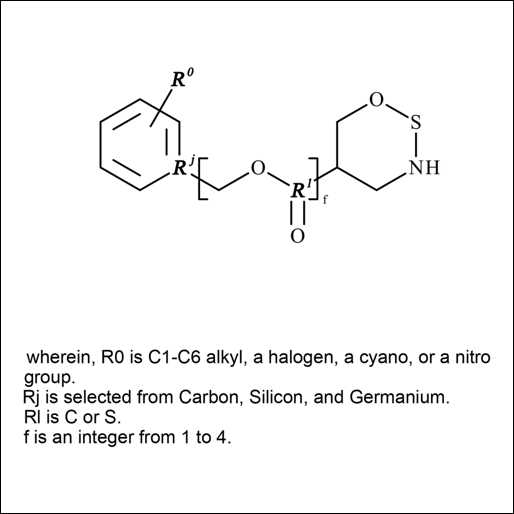

100%|██████████| 15000/15000 [00:00<00:00, 60877.83it/s]

Ouput:
<markush><cxsmi>*C.O=*(OC*1ccccc1)C1CNSOC1 |(4.04856,6.66423,;3.14856,5.10538,;7.99519,1.5,;7.99519,3,;6.69615,3.75,;5.39711,3,;4.09808,3.75,;4.09808,5.25,;2.79904,6,;1.5,5.25,;1.5,3.75,;2.79904,3,;9.29423,3.75,;10.5933,3,;11.8923,3.75,;11.8923,5.25,;10.5933,6,;9.29423,5.25,),atomProp:0.dummyLabel.R0:3.dummyLabel.Rl:6.dummyLabel.Rj,Sg:n:2,3,4,5:F:ht:::|</cxsmi><stable>F:9-18<ns>
Rj:C<n>CH<n>N<ns>
R0:lower alkoxy (C1-6)<n>optionally substituted C1-C10 alkyl<ns>
Rl:a Tin atom<n>a Germanium atom</stable></markush>
[{'text': 'Rj', 'bbox': [0.3330078125, 0.298828125, 0.3779296875, 0.3388671875]}, {'text': 'O', 'bbox': [0.7197265625, 0.1767578125, 0.7451171875, 0.2041015625]}, {'text': 'S', 'bbox': [0.80078125, 0.220703125, 0.818359375, 0.25]}, {'text': 'O', 'bbox': [0.48828125, 0.3095703125, 0.5146484375, 0.3388671875]}, {'text': 'f is an integer from 1 to 4.', 'bbox': [0.0439453125, 0.8310546875, 0.44921875, 0.8701171875]}, {'text': 'O', 'bbox': [0.5654296875, 0.443359375, 0.5908203

In [89]:
description_generator = DescriptionGenerator()
image_text_merger = ImageTextMerger()

verbose = True
display_cells = False
pages_images = []
annotations = []
for i in tqdm(range(0, 15000)):
    if not(i in [8014]): # Intersting figure for the "Dream experiment"
        continue
    image, image_path, cxsmiles, cxsmiles_dataset, cxsmiles_opt, cells = dataset_hf[i]["image"], dataset_hf[i]["image_path"], dataset_hf[i]["cxsmiles"], dataset_hf[i]["cxsmiles_dataset"], dataset_hf[i]["cxsmiles_opt"], dataset_hf[i]["cells"]
    print(dataset_hf[i])
    if not(("Sg" in cxsmiles_opt) and ("m" in cxsmiles_opt) and (len(cxsmiles_opt) < 100)):
        continue
    
    if verbose:
        print("index", i)
        print("image_path", image_path)
        print("cxsmiles_dataset", cxsmiles_dataset)
        print("cxsmiles", cxsmiles)
        print("cxsmiles_opt", cxsmiles_opt)
        
    description, annotation = description_generator.generate(cxsmiles, cxsmiles_dataset)
    description = "wherein, R0 is C1-C6 alkyl, a halogen, a cyano, or a nitro group. \n Rj is selected from Carbon, Silicon, and Germanium. \n Rl is C or S. \n f is an integer from 1 to 4."
    try:
        stable_string = re.search(re.escape("<stable>") + r'(.*?)' + re.escape("</stable>"), annotation).group(1) 
    except:
        print(annotation)
        print(description)
        print(f"Error for {i}")
        break
    if verbose:
        print("----------------------------------------------------------------------------------")
        print(stable_string.replace("<ns>", "<ns>\n"))
        print("----------------------------------------------------------------------------------")
        print("description")
        print(description)
        print("annotation")
        print(annotation)
    
    print(cells)
    cells.append({'bbox': [0.6555, 0.615, 0.675, 0.645], 'text': 'Rl'})    
                 
    page, page_cells = image_text_merger.create_page(image, cells, description, display_cells=display_cells)
    page = page.resize((512, 512))
    if verbose:
        print("Input page:")
        display(ImageOps.expand(page, border=1, fill="black"))#.resize((page.size[0]//5, page.size[1]//5)))

    if verbose:
        print("Ouput:")
        description_generator.print_annotation(annotation)
        print("="*30)
        
    pages_images.append(page)
    annotations.append(annotation)
    if verbose:
        print(page_cells)

### Save samples paper figure dataset

In [90]:
page_dataset_name = "pf_1"
samples = {}
# Selected CXSMILES: i: 8014 dataset: ocxsr_3005

In [91]:
id = 0
page_image_path = os.getcwd() + f"/../../data/dataset/{page_dataset_name}/page_images/{id}.png"
page.save(page_image_path)
samples[id] = {
    "id": id, 
    "page_image_path": page_image_path,
    "description": "wherein, R0 is C1-C6 alkyl, a halogen, a cyano, or a nitro group. \n Rj is selected from Carbon, Silicon, and Germanium. \n Rl is C or S. \n f is an integer from 1 to 4.",
    "annotation": "<markush><cxsmi>*C.O=*(OC*1ccccc1)C1CNSOC1 |(4.04856,6.66423,;3.14856,5.10538,;7.99519,1.5,;7.99519,3,;6.69615,3.75,;5.39711,3,;4.09808,3.75,;4.09808,5.25,;2.79904,6,;1.5,5.25,;1.5,3.75,;2.79904,3,;9.29423,3.75,;10.5933,3,;11.8923,3.75,;11.8923,5.25,;10.5933,6,;9.29423,5.25,),atomProp:0.dummyLabel.R0:3.dummyLabel.Rl:6.dummyLabel.Rj,Sg:n:2,3,4,5:F:ht:::|</cxsmi><stable>F:3-16<ns>R0:i-Bu<n>C4H9(i)<ns>Rj:CH<n>C<n>N<ns>Rl:C<n>Ge<n>Si</stable></markush>",
    "mol": "\n     RDKit          2D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 18 18 1 0 0\nM  V30 BEGIN ATOM\nM  V30 1 O 7.995190 1.500000 0.000000 0\nM  V30 2 Rl 7.995190 3.000000 0.000000 0\nM  V30 3 O 6.696150 3.750000 0.000000 0\nM  V30 4 C 5.397110 3.000000 0.000000 0\nM  V30 5 Rj 4.098080 3.750000 0.000000 0\nM  V30 6 C 4.098080 5.250000 0.000000 0\nM  V30 7 C 2.799040 6.000000 0.000000 0\nM  V30 8 C 1.500000 5.250000 0.000000 0\nM  V30 9 C 1.500000 3.750000 0.000000 0\nM  V30 10 C 2.799040 3.000000 0.000000 0\nM  V30 11 C 9.294230 3.750000 0.000000 0\nM  V30 12 C 10.593270 3.000000 0.000000 0\nM  V30 13 N 11.892300 3.750000 0.000000 0\nM  V30 14 S 11.892300 5.250000 0.000000 0\nM  V30 15 O 10.593270 6.000000 0.000000 0\nM  V30 16 C 9.294230 5.250000 0.000000 0\nM  V30 17 C 3.148560 5.105380 0.000000 0\nM  V30 18 R# 4.048560 6.664230 0.000000 0 RGROUPS=(1 0)\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 2 1 2\nM  V30 2 1 2 3\nM  V30 3 1 3 4\nM  V30 4 1 4 5\nM  V30 5 4 5 6\nM  V30 6 4 6 7\nM  V30 7 4 7 8\nM  V30 8 4 8 9\nM  V30 9 4 9 10\nM  V30 10 4 5 10\nM  V30 11 1 2 11\nM  V30 12 1 11 12\nM  V30 13 1 12 13\nM  V30 14 1 13 14\nM  V30 15 1 14 15\nM  V30 16 1 15 16\nM  V30 17 1 11 16\nM  V30 18 1 17 18 ENDPTS=(6 5 6 7 8 9 10) ATTACH=ANY\nM  V30 END BOND\nM  V30 BEGIN SGROUP\nM  V30 1 SRU 0 ATOMS=(4 1 2 3 4) XBONDS=(2 4 11) CONNECT=HT LABEL=F -\nM  V30 BRKXYZ=(9 4.7476 4.0500 0 4.7476 2.7000 0 0 0 0) BRKXYZ=(9 8.6447 4.050-\nM  V30 0 0 8.6447 2.7000 0 0 0 0)\nM  V30 END SGROUP\nM  V30 END CTAB\nM  END\n",
    "cxsmiles_dataset": "O=C(OCC1=CC=CC=C1)C1CNSOC1.CC |$;Rl;;;Rj;;;;;;;;;;;;;R0$,m:16:5.6.7.8.9.4,Sg:n:0,1,2,3:F:ht|",
    "cxsmiles": "*C.O=*(OC*1ccccc1)C1CNSOC1 |(4.04856,6.66423,;3.14856,5.10538,;7.99519,1.5,;7.99519,3,;6.69615,3.75,;5.39711,3,;4.09808,3.75,;4.09808,5.25,;2.79904,6,;1.5,5.25,;1.5,3.75,;2.79904,3,;9.29423,3.75,;10.5933,3,;11.8923,3.75,;11.8923,5.25,;10.5933,6,;9.29423,5.25,),atomProp:0.dummyLabel.R0:3.dummyLabel.Rl:6.dummyLabel.Rj,Sg:n:2,3,4,5:F:ht:::|",
    "cxsmiles_opt": "<r>R0</r>C.O=<r>Rl</r>(OC<r>Rj</r>1ccccc1)C1CNSOC1|Sg:n:2,3,4,5:F:ht,m:1:6.7.8.9.10.11",
    "keypoints": [[4.04856, 6.66423], [3.14856, 5.10538], [7.99519, 1.5], [7.99519, 3.0], [6.69615, 3.75], [5.39711, 3.0], [4.09808, 3.75], [4.09808, 5.25], [2.79904, 6.0], [1.5, 5.25], [1.5, 3.75], [2.79904, 3.0], [9.29423, 3.75], [10.5933, 3.0], [11.8923, 3.75], [11.8923, 5.25], [10.5933, 6.0], [9.29423, 5.25]],
    "cells": [{'text': 'Rl', 'bbox': [0.5693359375, 0.34375, 0.6103515625, 0.380859375]}, {'text': 'O', 'bbox': [0.724609375, 0.1748046875, 0.7509765625, 0.203125]}, {'text': 'Rj is selected from Carbon, Silicon, and Germanium.', 'bbox': [0.0478515625, 0.7529296875, 0.8857421875, 0.79296875]}, {'text': 'f is an integer from 1 to 4.', 'bbox': [0.0439453125, 0.8310546875, 0.4521484375, 0.87109375]}, {'text': 'wherein, R0 is C1-C6 alkyl, a halogen, a cyano, or a nitro', 'bbox': [0.0458984375, 0.6748046875, 0.955078125, 0.7138671875]}, {'text': 'S', 'bbox': [0.806640625, 0.2197265625, 0.82421875, 0.248046875]}, {'text': 'group.', 'bbox': [0.0439453125, 0.7138671875, 0.1455078125, 0.7529296875]}, {'text': 'O', 'bbox': [0.4931640625, 0.3095703125, 0.51953125, 0.3369140625]}, {'text': 'O', 'bbox': [0.5703125, 0.4423828125, 0.5966796875, 0.470703125]}, {'text': 'R0', 'bbox': [0.3349609375, 0.126953125, 0.3798828125, 0.1630859375]}, {'text': 'Rl', 'bbox': [0.6328125, 0.3759765625, 0.646484375, 0.3955078125]}, {'text': 'N', 'bbox': [0.80078125, 0.3095703125, 0.8623046875, 0.3359375]}, {'text': 'Rj', 'bbox': [0.337890625, 0.296875, 0.3818359375, 0.3369140625]}, {'text': 'Rl is C or S.', 'bbox': [0.0419921875, 0.7919921875, 0.232421875, 0.8251953125]}]
}

In [84]:
# Create hf dataset
def read_samples(samples, ts):
    for sample in samples.values():
        sample["page_image"] = Image.open(sample["page_image_path"])
        yield sample
        
dataset_hf = Dataset.from_generator(functools.partial(read_samples, samples=samples, ts=f"{time()}"))

dataset_hf_name = "pf_1_hf"
dataset_hf = DatasetDict({"test": dataset_hf})
dataset_hf.save_to_disk(os.getcwd() + f"/../../../deepsearch-ai-unidoc/data/{dataset_hf_name}")  

Generating train split: 1 examples [00:00, 250.41 examples/s]
Saving the dataset (1/1 shards): 100%|██████████| 1/1 [00:00<00:00, 151.95 examples/s]


### Save samples cross modalities dataset

In [5]:
page_dataset_name = "cm_1"
samples = {}
# Selected CXSMILES: i: 114 dataset: ocxsr_3004

In [6]:
id = 0
page_image_path = os.getcwd() + f"/../../data/dataset/{page_dataset_name}/page_images/{id}.png"
page.save(page_image_path)
samples[id] = {
    "id": id, 
    "page_image_path": page_image_path,
    "description": "wherein B'' is OH.",
    "annotation": "<markush><cxsmi>*C(C)C(=N)C=N |(0.32476,3.9375,;0.32476,2.4375,;1.6238,1.6875,;-0.97428,1.6875,;-0.97428,0.1875,;-2.27332,2.4375,;-3.57235,1.6875,),atomProp:0.dummyLabel.B''|</cxsmi><stable>B'':OH</stable></markush>",
    "mol": "\n     RDKit          2D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 7 6 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 1.623800 1.687500 0.000000 0\nM  V30 2 C 0.324760 2.437500 0.000000 0\nM  V30 3 B'' 0.324760 3.937500 0.000000 0\nM  V30 4 C -0.974280 1.687500 0.000000 0\nM  V30 5 N -0.974280 0.187500 0.000000 0\nM  V30 6 C -2.273320 2.437500 0.000000 0\nM  V30 7 N -3.572350 1.687500 0.000000 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 1 1 2\nM  V30 2 1 2 3\nM  V30 3 1 2 4\nM  V30 4 2 4 5\nM  V30 5 1 4 6\nM  V30 6 2 6 7\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n",
    "cxsmiles_dataset": "CC(C)C(=N)C=N |$;;B'';;;;$|",
    "cxsmiles": "*C(C)C(=N)C=N |(0.32476,3.9375,;0.32476,2.4375,;1.6238,1.6875,;-0.97428,1.6875,;-0.97428,0.1875,;-2.27332,2.4375,;-3.57235,1.6875,),atomProp:0.dummyLabel.B''|",
    "cxsmiles_opt": "<r>B''</r>C(C)C(=N)C=N",
    "keypoints":  [[0.32476, 3.9375], [0.32476, 2.4375], [1.6238, 1.6875], [-0.97428, 1.6875], [-0.97428, 0.1875], [-2.27332, 2.4375], [-3.57235, 1.6875]],
    "cells": [{'text': 'N', 'bbox': [0.21484375, 0.4697265625, 0.2724609375, 0.5029296875]}, {'text': "B''", 'bbox': [0.759765625, 0.1337890625, 0.8076171875, 0.173828125]}, {'text': 'N', 'bbox': [0.5849609375, 0.6494140625, 0.642578125, 0.68359375]}, {'text': "wherein B'' is OH.", 'bbox': [0.0439453125, 0.8251953125, 0.38671875, 0.865234375]}]
}

In [8]:
id = 1
page_image_path = os.getcwd() + f"/../../data/dataset/{page_dataset_name}/page_images/{id}.png"
page.save(page_image_path)
samples[id] = {
    "id": id, 
    "page_image_path": page_image_path,
    "description": "wherein B'' is O.",
    "annotation": "<markush><cxsmi>*C(C)C(=N)C=N |(0.32476,3.9375,;0.32476,2.4375,;1.6238,1.6875,;-0.97428,1.6875,;-0.97428,0.1875,;-2.27332,2.4375,;-3.57235,1.6875,),atomProp:0.dummyLabel.B''|</cxsmi><stable>B'':O</stable></markush>",
    "mol": "\n     RDKit          2D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 7 6 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 1.623800 1.687500 0.000000 0\nM  V30 2 C 0.324760 2.437500 0.000000 0\nM  V30 3 B'' 0.324760 3.937500 0.000000 0\nM  V30 4 C -0.974280 1.687500 0.000000 0\nM  V30 5 N -0.974280 0.187500 0.000000 0\nM  V30 6 C -2.273320 2.437500 0.000000 0\nM  V30 7 N -3.572350 1.687500 0.000000 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 1 1 2\nM  V30 2 1 2 3\nM  V30 3 1 2 4\nM  V30 4 2 4 5\nM  V30 5 1 4 6\nM  V30 6 2 6 7\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n",
    "cxsmiles_dataset": "CC(C)C(=N)C=N |$;;B'';;;;$|",
    "cxsmiles": "*C(C)C(=N)C=N |(0.32476,3.9375,;0.32476,2.4375,;1.6238,1.6875,;-0.97428,1.6875,;-0.97428,0.1875,;-2.27332,2.4375,;-3.57235,1.6875,),atomProp:0.dummyLabel.B''|",
    "cxsmiles_opt": "<r>B''</r>C(C)C(=N)C=N",
    "keypoints":  [[0.32476, 3.9375], [0.32476, 2.4375], [1.6238, 1.6875], [-0.97428, 1.6875], [-0.97428, 0.1875], [-2.27332, 2.4375], [-3.57235, 1.6875]],
    "cells": [{'text': "B''", 'bbox': [0.759765625, 0.1337890625, 0.8076171875, 0.173828125]}, {'text': "wherein B'' is O.", 'bbox': [0.0439453125, 0.8251953125, 0.35546875, 0.865234375]}, {'text': 'N', 'bbox': [0.5849609375, 0.6494140625, 0.642578125, 0.68359375]}, {'text': 'N', 'bbox': [0.21484375, 0.4697265625, 0.2724609375, 0.5029296875]}]
}

In [10]:
# Create hf dataset
def read_samples(samples, ts):
    for sample in samples.values():
        sample["page_image"] = Image.open(sample["page_image_path"])
        yield sample
        
dataset_hf = Dataset.from_generator(functools.partial(read_samples, samples=samples, ts=f"{time()}"))

dataset_hf_name = "cm_1_hf"
dataset_hf = DatasetDict({"test": dataset_hf})
dataset_hf.save_to_disk(os.getcwd() + f"/../../../deepsearch-ai-unidoc/data/{dataset_hf_name}")  

In [ ]:
# Note: Paper image: /mnt/volume/lum/molecule-depictor-cdk/mol_depict_cdk/../data/dataset/experiment-cx3000_cxsmiles_ocr/images_png/1881556.png (ocxsr_3004)